In [1]:
from am4pa.linnea import LinneaConfig, DataManagerLinnea
from va4algs import RankingModel
import pandas as pd
pd.set_option('display.max_rows', None)
from va4algs import RulesDiscovery, AnalysisType

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from va4algs import RankingDataLinnea
from va4algs import VCDataLinnea

In [3]:
EXPRESSION_FILE = '../experiments/measurements/linnea-expressions/gls.py'
EXPERIMENT_ID = 'GLS-ix01'

In [4]:
SERVER = "login18-1.hpc.itc.rwth-aachen.de"
UNAME = "as641651"
BACK_END_FOLDER = "~/PhD/va4algs-exps/"
FRONT_END_FOLDER = "../experiments/measurements/codes/"

In [5]:
linnea_config = LinneaConfig(EXPRESSION_FILE)
linnea_config.set_local_directory("{}{}".format(FRONT_END_FOLDER,EXPERIMENT_ID))
linnea_config.setup_backend_details(server=SERVER,
                                   uname = UNAME,
                                   init_script="~/.analyzer",
                                   backend_root=BACK_END_FOLDER)
linnea_config.connect_backend()

In [6]:
dml = DataManagerLinnea(linnea_config,read_only=True)

In [7]:
print(len(dml.measurements_data['24T']))
print(len(dml.operands_data['24T']))

105
105


In [8]:
THREADS = '24T'
RANKING_METHOD = 3

In [9]:
rm = RankingModel(name='R{}'.format(RANKING_METHOD),method=RANKING_METHOD)
rdl = RankingDataLinnea(dml,rm,THREADS)
rdl.load()

In [10]:
print("Percent Anomalies: {}".format(rdl.percent_anomalies))
print("Average Risk: {}".format(rdl.avg_risk))
print("Average Adjusted Risk: {}".format(rdl.avg_adj_risk))

Percent Anomalies: 0.06666666666666667
Average Risk: 0.04867724867724867
Average Adjusted Risk: 0.012685914607639084


In [11]:
rdl.filter_interesting_operands(adj_risk_thresh=0.0)

,op_str,num_algs,max-rel-flops,is_anomaly,n_rel0,n_anomalies,risk,time_inc,rel_inc,adj_risk,rel-flops-cutoff
62,337_249,100,0.733333,True,9,9,1.000000,0.000273,0.339285,0.339285,0.733333
64,313_166,100,0.672087,True,9,9,1.000000,0.000154,0.239026,0.239026,0.672087
45,378_172,100,0.637993,True,9,9,1.000000,0.000104,0.177785,0.177785,0.637993
57,740_50,100,0.048485,True,27,18,0.666667,0.000372,0.351967,0.234645,0.000000
31,699_47,100,0.043165,True,27,18,0.666667,0.000326,0.295212,0.196808,0.000000
56,672_35,100,0.033898,True,27,18,0.666667,0.000178,0.204800,0.136533,0.000000
75,1324_889,100,0.718232,True,9,1,0.111111,0.000557,0.071449,0.007939,0.000000


### We want to answer three questions:

1) Why does some min flops alg do not end up in the best class? Analysis type 1

2) Why does sometimes none of the min flops alg end up in the best class? Analyis type 2

3) What kind of data can we use when none of the min flop algs are in rank 0? Analysis type 3, type4, type 5



In [25]:
from enum import Enum

In [83]:
class AnalysisType(Enum):
    TYPE1 = 1
    TYPE2 = 2
    TYPE3 = 3
    TYPE4 = 4
    TYPE5 = 5

class RulesDiscovery:
    def __init__(self,rdl:RankingDataLinnea):
        self.rdl = rdl
        self.dml = rdl.dml
        self.thred_str = rdl.thread_str
        
        self.vc = VCDataLinnea(self.rdl)
        self.da = self.rdl.data_anomalies
        
        self.data_kernels = {}
        self.data_relations = {}
        
    def get_analysis_data(self, a_type:AnalysisType):
        try:       
            return self.data_kernels[a_type], self.data_relations[a_type]
        except KeyError:
            pass
            
        
        nodes = []
        edges = []
        
        if a_type == AnalysisType.TYPE1:
            ## only min flops
            op_strs = self.da[self.da['adj_risk']>0.0]['op_str'].tolist()
            vc_f = self.vc.get_vc1
        elif a_type == AnalysisType.TYPE2:
            ## rank 0 vs min flops for rel flops > 0
            op_strs = self.da[self.da['rel-flops-cutoff']>0.0]['op_str'].tolist()
            vc_f = self.vc.get_vc2
        elif a_type == AnalysisType.TYPE3: 
            ## only rel-flops cut off > 0
            op_strs = self.da[self.da['rel-flops-cutoff']>0.0]['op_str'].tolist()
            vc_f = self.vc.get_vc3
        elif a_type == AnalysisType.TYPE4:  
            ## vc3 with adj_risk > 0
            op_strs = self.da[self.da['adj_risk']>0.0]['op_str'].tolist()
            vc_f = self.vc.get_vc3
        elif a_type == AnalysisType.TYPE5:
            ## All ops best vs rest
            op_strs = self.da['op_str'].tolist()
            vc_f = self.vc.get_vc     
        else:
            print("Choose a relavant analysis type: 1, 2 or 3")
            return    
            
        
        for op_str in op_strs:
            
            ret, vc = vc_f(op_str)
            if ret == 1: 
                dn, de = vc.get_diff_data()
                dn['operands'] = op_str
                de['operands'] = op_str

                nodes.append(dn)
                edges.append(de)
            
        if nodes:
            self.data_kernels[a_type] = pd.concat(nodes).reset_index(drop=True)
            self.data_relations[a_type] = pd.concat(edges).reset_index(drop=True)
            self.data_kernels[a_type], self.data_relations[a_type] = self._prepare_kernel_relations_data(self.data_kernels[a_type],
                                                                                            self.data_relations[a_type])
        
            return self.data_kernels[a_type], self.data_relations[a_type]
        else:
            return None,None

    
    def discover_kernel_rules(self,a_type:AnalysisType):
        df_k, _ = self.get_analysis_data(a_type)
        
        sa = df_k.groupby(["kernel", "class"])['class'].count().unstack(fill_value=0)
        sa = self._add_missing_class_data(sa)
        sa = self._compute_class_statistics(sa)
        s2 = sa[(sa['good (%)'] == 1.0) | (sa['bad (%)'] == 1.0)].reset_index()
        
        return s2
    
    def discover_relations_rules(self, a_type):
        _, df_r = self.get_analysis_data(a_type)
        
        sa = df_r.groupby(["kernelA", "kernelB", "class"])['class'].count().unstack(fill_value=0)
        sa = self._add_missing_class_data(sa)
        sa = self._compute_class_statistics(sa)
        
        s2 = sa[(sa['good (%)'] == 1.0) | (sa['bad (%)'] == 1.0)].reset_index()
#         if filter_kernel_rules:
#             bl = self.rules['kernel'][1] + self.rules['kernel'][-1]
#             return s2[(~s2['kernelA'].isin(bl)) & (~s2['kernelB'].isin(bl))].reset_index(drop=True)
        return s2
    

    def _prepare_kernel_relations_data(self,data_kernels,data_relations):
        def get_flops(str_):
            if not '@@' in str_:
                return float(str_.split('_')[1])
            return 0
        data_kernels['flops'] = data_kernels.apply(lambda x: get_flops(x['node']), axis=1)
        data_kernels['kernel'] = data_kernels.apply(lambda x: x['node'].split('_')[0], axis=1)
        data_relations['flopsA'] = data_relations.apply(lambda x: get_flops(x['nodeA']), axis=1)
        data_relations['kernelA'] = data_relations.apply(lambda x: x['nodeA'].split('_')[0], axis=1)
        data_relations['flopsB'] = data_relations.apply(lambda x: get_flops(x['nodeB']), axis=1)
        data_relations['kernelB'] = data_relations.apply(lambda x: x['nodeB'].split('_')[0], axis=1)
        
        return data_kernels, data_relations
    
    def _add_missing_class_data(self, df):
        if not 1 in df.columns:
            df[1] = 0
        if not -1 in df.columns:
            df[-1] = 0
        return df
    
    def _compute_class_statistics(self, df):
        df['total'] = df.apply(lambda x: x[-1]+x[0]+x[1], axis=1)
        df['good (%)'] = df.apply(lambda x: x[1]/float(x['total']), axis=1).round(2)
        df['bad (%)'] = df.apply(lambda x: x[-1]/float(x['total']), axis=1).round(2)
        df['selection score'] = df.apply(lambda x: x[1]/float(x[1]+ x[-1]), axis=1).fillna(-1).round(2)
        return df.reset_index()
        
            

In [12]:
rd = RulesDiscovery(rdl)

In [13]:
rd.discover_kernel_rules(AnalysisType.TYPE1)

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprec

No min flop alg in best variants
No min flop alg in best variants
No min flop alg in best variants


/Users/aravind/.local/lib/python3.9/site-packages/va4algs/rule_discovery.py:131: RuntimeWarning: invalid value encountered in double_scalars
  df['selection score'] = df.apply(lambda x: x[1]/float(x[1]+ x[-1]), axis=1).fillna(-1).round(2)


class,index,kernel,-1,0,1,total,good (%),bad (%),selection score
0,2,qr,3,0,0,3,0.0,1.0,0.0
1,3,syev,3,0,0,3,0.0,1.0,0.0


In [14]:
rd.discover_relations_rules(AnalysisType.TYPE1)

/Users/aravind/.local/lib/python3.9/site-packages/va4algs/rule_discovery.py:131: RuntimeWarning: invalid value encountered in double_scalars
  df['selection score'] = df.apply(lambda x: x[1]/float(x[1]+ x[-1]), axis=1).fillna(-1).round(2)


class,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,1,gemv,@@endnode,3,0,0,3,0.0,1.0,0.0
1,2,gemv,gemv,6,0,0,6,0.0,1.0,0.0
2,3,gemv,potrf,0,0,4,4,1.0,0.0,1.0
3,4,gemv,qr,3,0,0,3,0.0,1.0,0.0
4,5,gemv,syev,3,0,0,3,0.0,1.0,0.0
5,11,qr,gemv,6,0,0,6,0.0,1.0,0.0
6,12,qr,trsv,3,0,0,3,0.0,1.0,0.0
7,13,syev,gemv,6,0,0,6,0.0,1.0,0.0
8,14,syev,trsv,3,0,0,3,0.0,1.0,0.0
9,17,syrk,qr,3,0,0,3,0.0,1.0,0.0


In [15]:
#dfk, dfr = rd.get_analysis_data(AnalysisType.TYPE2)

In [16]:
#rd.data_kernels

In [17]:
_,vcx = rd.vc.get_vc1('740_50')

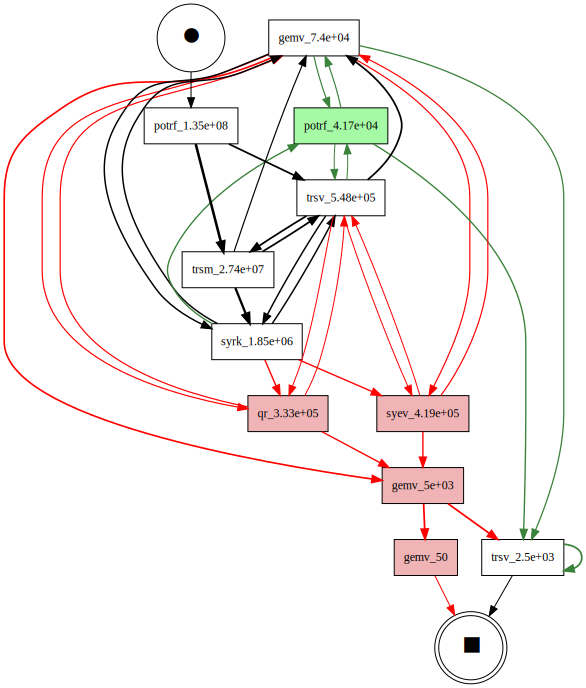

In [18]:
vcx.get_dfg_minus_best_worst()